# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
import thor

thor.setupOorb()
config = thor.Config()

In [3]:
DATABASE = "../data/msst_survey.db"
con = sql.connect(DATABASE)

## Config

In [4]:
from thor import Config

## Plotting Code

In [5]:
from thor.plotting import plotProjections
from thor.plotting import plotProjections3D
from thor.plotting import plotObservations
from thor.plotting import plotObservations3D
from thor.plotting import plotBinnedContour
from thor.plotting import plotScatterContour
from thor.plotting import plotCell

## Classes 

In [6]:
from thor import Cell
from thor import TestParticle

## Functions

In [7]:
from thor import findAverageObject
from thor import findExposureTimes
from thor import buildCellForVisit
from thor import rangeAndShift
from thor import clusterAndLink
from thor import analyzeClusters
from thor import runRangeAndShiftOnVisit
from thor import runClusterAndLinkOnVisit

# Load Data

In [8]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations""", con)
noise = pd.read_sql("""SELECT * FROM noise_100""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

In [9]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [10]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [11]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]

In [12]:
neos = orbits[orbits["a_au"] <= 1.3]["designation"].values

## Range and Shift

In [13]:
projected_obs, avgObject = runRangeAndShiftOnVisit(
    observations, 
    1, 
    0, 
    0, 
    useAverageObject=True, 
    searchArea=10, 
    cellArea=10)

THOR: runRangeAndShiftOnVisit
-------------------------
Running Thor on visit 1...
Search cell area: 10 
Search cell shape: square 
Cell area: 10 
Cell shape: square 

THOR: findAverageObject
-------------------------
p3143 is the most average object.
-------------------------

THOR: rangeAndShift
-------------------------
Running range and shift...
Assuming r = 2.7617290181 AU
Assuming v = [-0.00964426 -0.00379003  0.00017245] AU per day
Preparing rotation matrices...
Convering to ecliptic coordinates...
Calculating object to observer unit vector...
Calculating object to observer distance assuming r = 2.7617290181 AU...
Calculating object to observer position vector...
Calculating barycentic object position vector...
Calculating vector normal to plane of orbit...
Calculating R1 rotation matrix...
Calculating R2 rotation matrix...
Calculating final rotation matrix...
Done.

THOR: findExposureTimes
-------------------------
Generating particle ephemeris for the middle of every night.
Fi

## Cluster and Link

In [14]:
DO_CLUSTERING = False

In [15]:
if DO_CLUSTERING:
    for i in [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.1]:
        allClusters, clusterMembers = clusterAndLink(
            projected_obs,
            eps=i, 
            minSamples=5, 
            vxRange=[-0.1, 0.1], 
            vyRange=[-0.1, 0.1], 
            vxBins=100,
            vyBins=100, 
            threads=5)

        allClusters, clusterMembers, allObjects, summary = analyzeClusters(
            projected_obs,
            allClusters, 
            clusterMembers, 
            minSamples=5, 
            partialThreshold=5)

        summary.to_csv("eps_{}.txt".format(i), sep=" ", index=False)

In [16]:
if DO_CLUSTERING:
    for i in [400, 600, 1000]:
        allClusters, clusterMembers = clusterAndLink(
            projected_obs,
            eps=0.005, 
            minSamples=5, 
            vxRange=[-0.1, 0.1], 
            vyRange=[-0.1, 0.1], 
            vxBins=i,
            vyBins=i, 
            threads=5)

        allClusters, clusterMembers, allObjects, summary = analyzeClusters(
            projected_obs,
            allClusters, 
            clusterMembers, 
            minSamples=5, 
            partialThreshold=5)

        summary.to_csv("bins_{}.txt".format(i), sep=" ", index=False)

In [17]:
if DO_CLUSTERING:
    for i in [0.01, 0.05, 0.1, 0.5, 1, 5]:
        allClusters, clusterMembers = clusterAndLink(
            projected_obs,
            eps=0.005, 
            minSamples=5, 
            vxRange=[-i, i], 
            vyRange=[-i, i], 
            vxBins=100,
            vyBins=100, 
            threads=5)

        allClusters, clusterMembers, allObjects, summary = analyzeClusters(
            projected_obs,
            allClusters, 
            clusterMembers, 
            minSamples=5, 
            partialThreshold=5)

        summary.to_csv("range_{}_eps_0.005_ms_5_bins_100.txt".format(i), sep=" ", index=False)

In [27]:
# Combine files
DO_COMBINE = True

if DO_COMBINE:

    eps_files = glob.glob("eps_*.txt")
    dfs = []
    for f in eps_files:
        df = pd.read_csv(f, sep=" ", index_col=False)
        eps = f.split("_")[1][:-4]
        df["eps"] = float(eps)
        dfs.append(df)

    eps = pd.concat(dfs)
    eps.sort_values(by="eps", inplace=True)
    eps.to_csv("../analysis/msst/eps_summary.txt", sep=" ", index=False)

    bin_files = glob.glob("bins_*.txt")
    dfs = []
    for f in bin_files:
        df = pd.read_csv(f, sep=" ", index_col=False)
        bins = f.split("_")[1][:-4]
        df["bins"] = float(bins)
        dfs.append(df)

    bins = pd.concat(dfs)
    bins.sort_values(by="bins", inplace=True)
    bins.to_csv("../analysis/msst/bins_summary.txt", sep=" ", index=False)
    
    range_files = glob.glob("range_*.txt")
    dfs = []
    for f in range_files:
        df = pd.read_csv(f, sep=" ", index_col=False)
        range = f.split("_")[1]
        df["range"] = float(range)
        dfs.append(df)

    ranges = pd.concat(dfs)
    ranges.sort_values(by="range", inplace=True)
    ranges.to_csv("../analysis/msst/ranges_summary.txt", sep=" ", index=False)

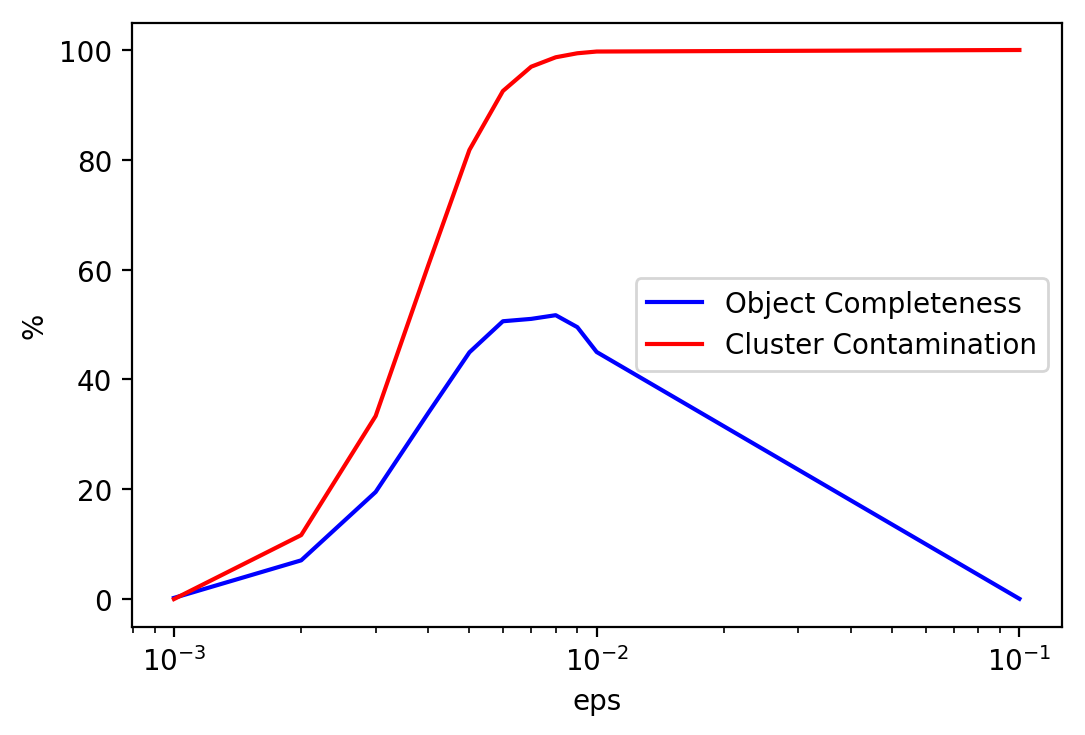

In [28]:
eps = pd.read_csv("../analysis/msst/eps_summary.txt", sep=" ", index_col=False)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(eps["eps"].values, eps["completeness"].values, label="Object Completeness", c="b")
ax.plot(eps["eps"].values, eps["cluster_contamination"].values, label="Cluster Contamination", c="r")
ax.set_xlabel("eps")
ax.set_ylabel("%")
ax.legend()
ax.set_xscale("log")
fig.savefig("../analysis/msst/plots/ROC_eps.png")

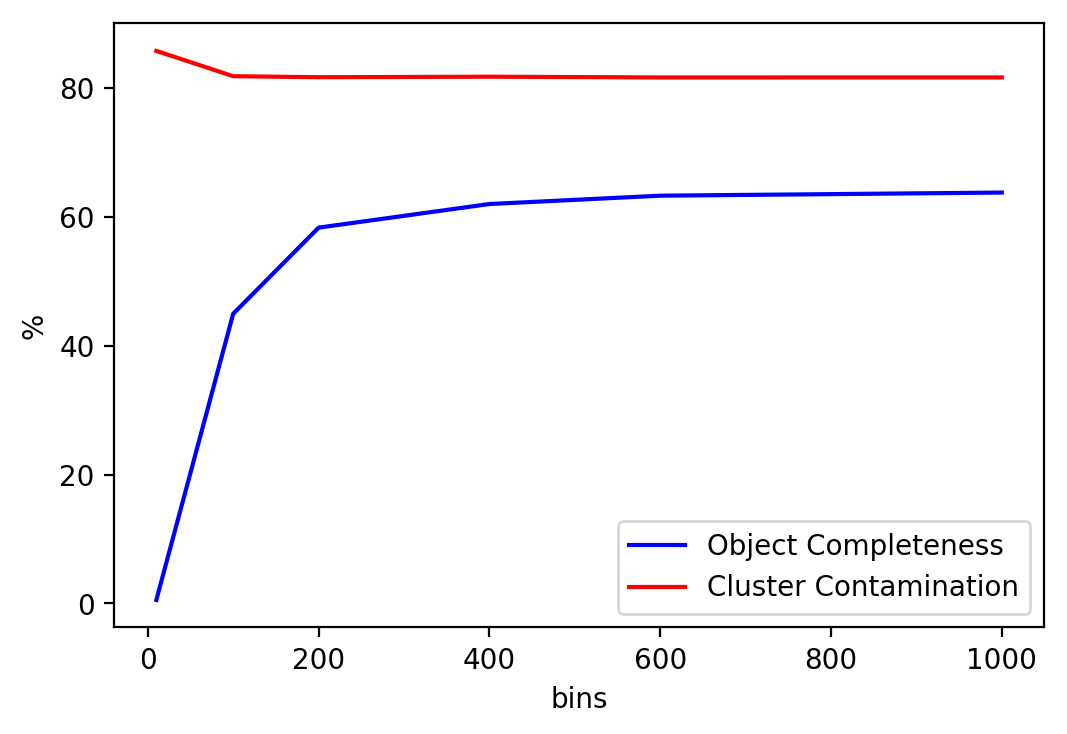

In [29]:
bins = pd.read_csv("../analysis/msst/bins_summary.txt", sep=" ", index_col=False)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(bins["bins"].values, bins["completeness"].values, label="Object Completeness", c="b")
ax.plot(bins["bins"].values, bins["cluster_contamination"].values, label="Cluster Contamination", c="r")
ax.set_xlabel("bins")
ax.set_ylabel("%")
ax.legend()
fig.savefig("../analysis/msst/plots/ROC_bins.png")

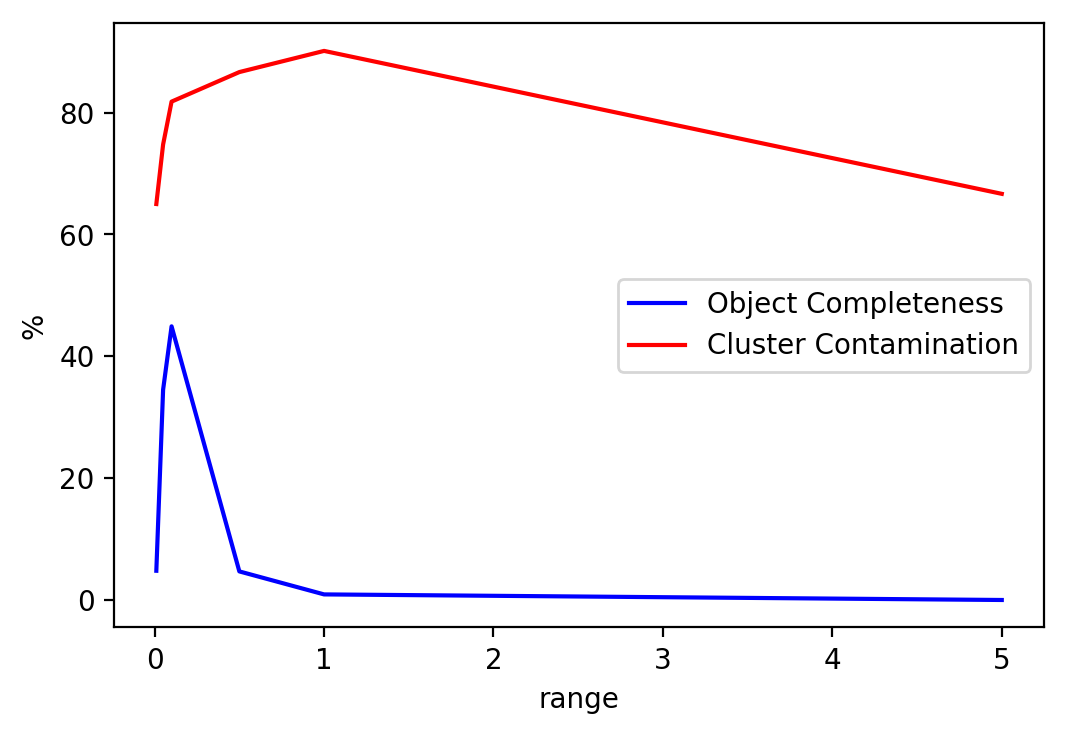

In [30]:
ranges = pd.read_csv("../analysis/msst/ranges_summary.txt", sep=" ", index_col=False)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(ranges["range"].values, ranges["completeness"].values, label="Object Completeness", c="b")
ax.plot(ranges["range"].values, ranges["cluster_contamination"].values, label="Cluster Contamination", c="r")
ax.set_xlabel("range")
ax.set_ylabel("%")
ax.legend()
fig.savefig("../analysis/msst/plots/ROC_ranges.png")